<a href="https://colab.research.google.com/github/mismatchgit/PyTorch-tutorial-freecodecamp/blob/main/pytorch_classification_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Make a binary classification dataset with Scikit-Learn's make_moons() function.

In [37]:
#import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 2
NUM_FEATURES = 2
RANDOM_SEED = 42

In [38]:
#Make 1000 samples
n_samples = 1000
#create circles
X, y = make_moons(n_samples,
                    noise = 0.03,                                              random_state=RANDOM_SEED)

In [39]:
len(X), len(y)

(1000, 1000)

In [40]:
y[:5]

array([1, 1, 1, 1, 0])

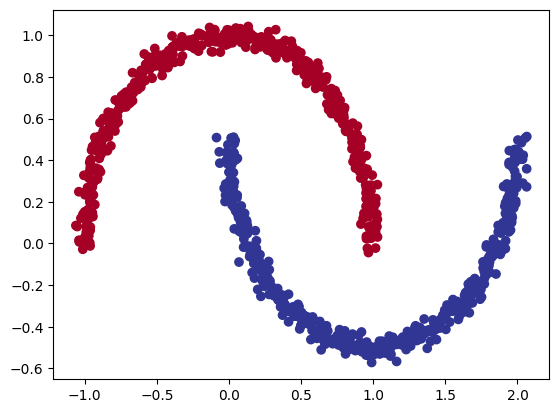

In [41]:
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [42]:
X[:, 0].shape

(1000,)

In [43]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 0.2 = 20% of data will be test & 80% will be train
                                                    random_state=RANDOM_SEED)

In [45]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

#2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.

In [46]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [47]:
class MoonModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=64) # takes in 2 features and upscales to 16 features
    self.layer_2 = nn.Linear(in_features=64, out_features=64) # takes in 16 features from previous layer and outputs 8 feature (same shape as y)
    self.layer_3 = nn.Linear(in_features=64, out_features=1) # takes in 8 features from previous layer and outputs a single feature (same shape as y)
    # self.layer_4 = nn.Linear(in_features=32, out_features=1) # takes in 8 features from previous layer and outputs a single feature (same shape as y)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()
    self.sigmoid = nn.Sigmoid()

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))) # x -> layer_1 ->  layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = MoonModelV0().to(device)
model_0

MoonModelV0(
  (layer_1): Linear(in_features=2, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
  (sigmoid): Sigmoid()
)

#3.Setup a binary classification compatible loss function and optimizer to use when training the model.

In [48]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.1)

#4.Create a training and testing loop to fit the model you created in 2 to the data you created in 1.

In [49]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [50]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 500

for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss (takes in logits as first input)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out what's this happenin'
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6858, Acc: 60.38% | Test Loss: 0.6762, Test Acc: 65.00%
Epoch: 10 | Loss: 0.5713, Acc: 80.00% | Test Loss: 0.5710, Test Acc: 80.00%
Epoch: 20 | Loss: 0.4634, Acc: 82.25% | Test Loss: 0.4711, Test Acc: 80.50%
Epoch: 30 | Loss: 0.3834, Acc: 83.00% | Test Loss: 0.3967, Test Acc: 81.00%
Epoch: 40 | Loss: 0.3365, Acc: 84.62% | Test Loss: 0.3507, Test Acc: 83.50%
Epoch: 50 | Loss: 0.3081, Acc: 85.25% | Test Loss: 0.3207, Test Acc: 84.00%
Epoch: 60 | Loss: 0.2884, Acc: 85.75% | Test Loss: 0.2986, Test Acc: 84.50%
Epoch: 70 | Loss: 0.2732, Acc: 86.12% | Test Loss: 0.2809, Test Acc: 86.50%
Epoch: 80 | Loss: 0.2605, Acc: 86.88% | Test Loss: 0.2658, Test Acc: 87.50%
Epoch: 90 | Loss: 0.2495, Acc: 87.50% | Test Loss: 0.2528, Test Acc: 88.50%
Epoch: 100 | Loss: 0.2398, Acc: 88.38% | Test Loss: 0.2412, Test Acc: 90.00%
Epoch: 110 | Loss: 0.2311, Acc: 88.75% | Test Loss: 0.2309, Test Acc: 90.00%
Epoch: 120 | Loss: 0.2231, Acc: 89.00% | Test Loss: 0.2216, Test Acc: 90.50%
Epoch: 130

#5.Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

In [51]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


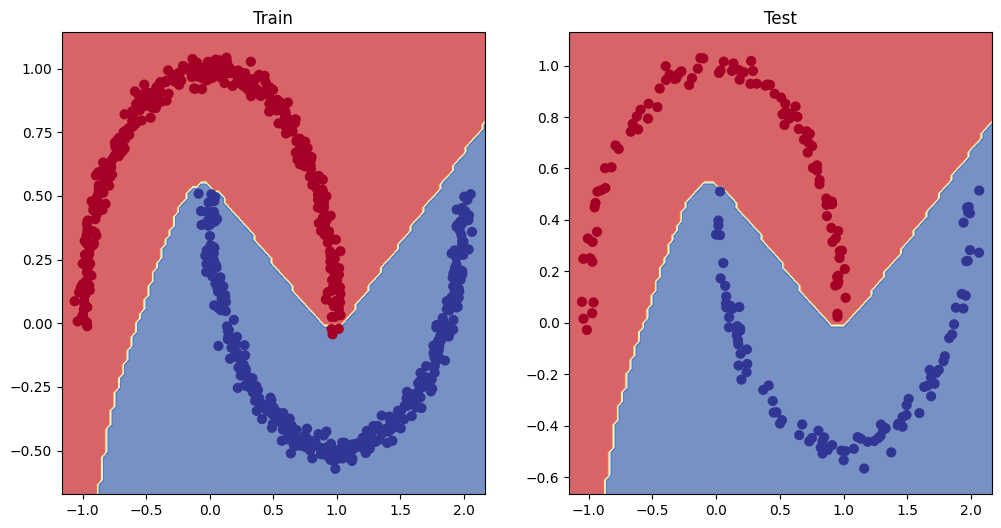

In [52]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

#6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.

In [53]:
import torch
import numpy as np
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32) #as the data type is defined it will be float32. By default it would be int64 as the increment is 1.
A.dtype

torch.float32

In [54]:
def tanh(z):
	return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

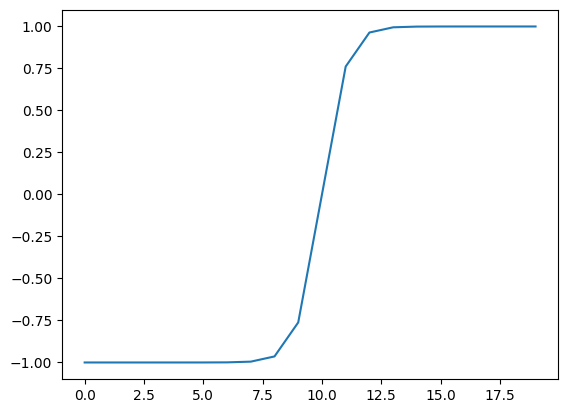

In [55]:
plt.plot(torch.tanh(A));

#7.Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).

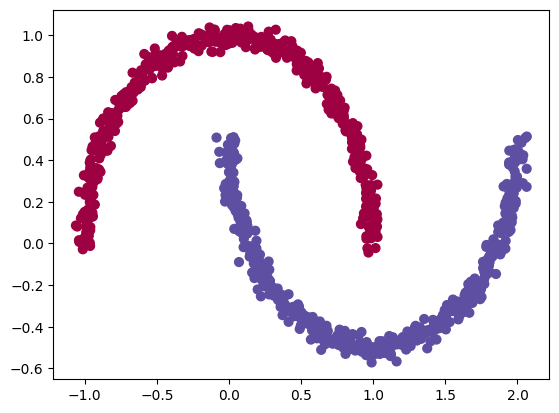

In [130]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 500 # number of points per class
D = 2 # dimensionality
K = 5 # number of classes
X2 = np.zeros((N*K,D)) # data matrix (each row = single example)
y2 = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.1 # theta
  X2[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y2[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [75]:
isinstance(X2, np.ndarray)

True

In [58]:
X2.shape

(2500, 2)

##Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).

In [131]:
# Turn data into tensors
X2 = torch.from_numpy(X2).type(torch.float)
y2 = torch.from_numpy(y2).type(torch.int64)

In [132]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,
                                                    y2,
                                                    test_size=0.2, # 0.2 = 20% of data will be test & 80% will be train
                                                    random_state=RANDOM_SEED)

In [133]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [145]:
class SpiralsModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=128) # takes in 2 features and upscales to 16 features
    self.layer_2 = nn.Linear(in_features=128, out_features=128) # takes in 16 features from previous layer and outputs 8 feature (same shape as y)
    self.layer_3 = nn.Linear(in_features=128, out_features=5) # takes in 8 features from previous layer and outputs a single feature (same shape as y)
    # self.layer_4 = nn.Linear(in_features=32, out_features=1) # takes in 8 features from previous layer and outputs a single feature (same shape as y)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()
    self.sigmoid = nn.Sigmoid()

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_3(self.sigmoid(self.layer_2(self.sigmoid(self.layer_1(x))))) # x -> layer_1 ->  layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_1 = SpiralsModelV0().to(device)
model_1

SpiralsModelV0(
  (layer_1): Linear(in_features=2, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
  (sigmoid): Sigmoid()
)

In [119]:
# Let's get some raw outputs of our model (logits)
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X2_test.to(device))

y_logits[:10]
print(y_logits.shape)
y2_train.dtype#----> This has to be integer. This is why error thrown in the training loop line 17.

torch.Size([500, 1])


torch.int64

In [64]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.0891,  0.0519, -0.1195,  0.0612,  0.0532],
        [-0.0629,  0.0347, -0.1359,  0.0014,  0.2007],
        [-0.0531,  0.0486, -0.1398,  0.0063,  0.1726],
        [-0.0590,  0.0555, -0.1206,  0.0624,  0.0234],
        [-0.0578,  0.0650, -0.1354,  0.0123,  0.1285]])
tensor([[0.1839, 0.2118, 0.1784, 0.2138, 0.2121],
        [0.1852, 0.2042, 0.1721, 0.1975, 0.2410],
        [0.1873, 0.2074, 0.1718, 0.1988, 0.2348],
        [0.1895, 0.2125, 0.1782, 0.2140, 0.2058],
        [0.1875, 0.2120, 0.1735, 0.2011, 0.2259]])


In [116]:
# Convert our model's prediction probabilities to prediction labels
#y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds = torch.argmax(torch.softmax(y_logits, dim=1),dim=1)
y_preds
torch.unique(y2_train)

tensor([0, 1, 2, 3, 4])

##Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working)

In [146]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),
                            lr=0.01)

In [129]:
y2_logits = model_1(X2_train)
#loss = loss_fn(y2_logits, y2_train)
y2_logits[:10]

tensor([[-0.0933],
        [-0.1535],
        [-0.1345],
        [-0.0471],
        [-0.1293],
        [-0.0793],
        [-0.1532],
        [-0.1484],
        [-0.1304],
        [-0.0764]], grad_fn=<SliceBackward0>)

##Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).

In [147]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Loop through data
epochs = 500

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y2_logits = model_1(X2_train)
  y2_pred = torch.argmax(torch.softmax(y2_logits, dim=1),dim=1) # logits -> prediction probabilities -> prediction labels

  # 2. Calculate the loss
  loss = loss_fn(y2_logits, y2_train) # BCEWithLogitsLoss (takes in logits as first input)
  acc = accuracy_fn(y_true=y2_train,
                    y_pred=y2_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X2_test)
    test_pred = torch.argmax(torch.softmax(test_logits, dim=1),dim=1)

    test_loss = loss_fn(test_logits, y2_test)
    test_acc = accuracy_fn(y_true=y2_test,
                           y_pred=test_pred)

  # Print out what's this happenin'
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.6878, Acc: 20.60% | Test Loss: 1.6716, Test Acc: 20.00%
Epoch: 10 | Loss: 1.5680, Acc: 29.65% | Test Loss: 1.5539, Test Acc: 33.00%
Epoch: 20 | Loss: 1.4318, Acc: 32.90% | Test Loss: 1.4055, Test Acc: 34.20%
Epoch: 30 | Loss: 1.2727, Acc: 32.05% | Test Loss: 1.2590, Test Acc: 30.40%
Epoch: 40 | Loss: 1.2327, Acc: 32.95% | Test Loss: 1.2323, Test Acc: 31.20%
Epoch: 50 | Loss: 1.2031, Acc: 34.45% | Test Loss: 1.1985, Test Acc: 32.80%
Epoch: 60 | Loss: 1.1512, Acc: 37.00% | Test Loss: 1.1471, Test Acc: 34.20%
Epoch: 70 | Loss: 1.0586, Acc: 45.60% | Test Loss: 1.0486, Test Acc: 44.00%
Epoch: 80 | Loss: 0.9312, Acc: 58.60% | Test Loss: 0.9204, Test Acc: 58.80%
Epoch: 90 | Loss: 0.8098, Acc: 65.25% | Test Loss: 0.8050, Test Acc: 66.60%
Epoch: 100 | Loss: 0.7101, Acc: 73.35% | Test Loss: 0.7096, Test Acc: 73.60%
Epoch: 110 | Loss: 0.6292, Acc: 79.15% | Test Loss: 0.6343, Test Acc: 78.60%
Epoch: 120 | Loss: 0.5606, Acc: 83.40% | Test Loss: 0.5688, Test Acc: 83.20%
Epoch: 130

In [ ]:
y_logits.shape, y2_train.shape

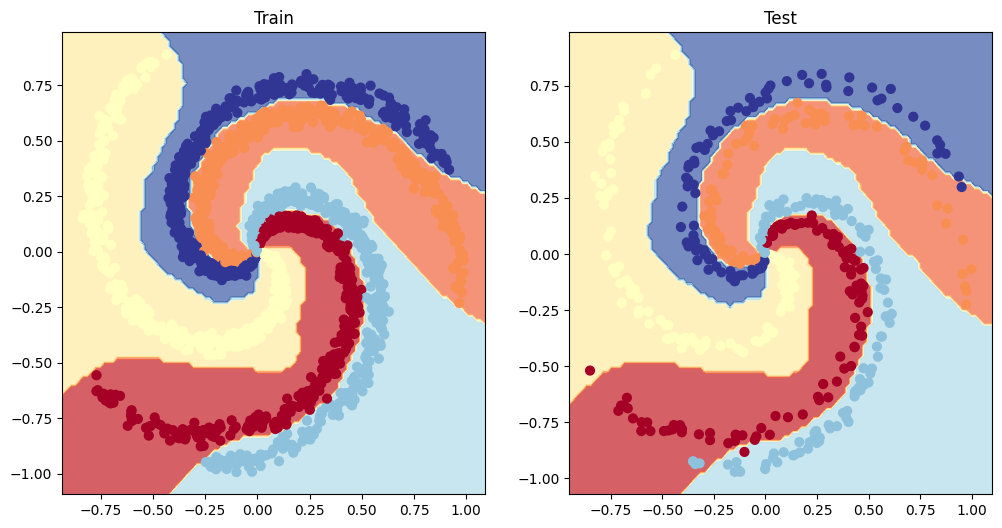

In [148]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X2_train, y2_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X2_test, y2_test)